In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
from datetime import datetime
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics

from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet

In [3]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Statsmodels version {sm.__version__}")

Working with these versions of libraries

Numpy version 1.22.4
Pandas version 1.5.3
Statsmodels version 0.13.5


In [4]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3, lags= 7)

    plt.suptitle(t = title, fontsize = 20)

### Importación datasets

In [5]:
df_cust_comm_act = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_commercial_activity.csv',
                               index_col = 0)

In [6]:
df_cust_prod = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_products.csv',
                           index_col = 0)

In [7]:
df_cust_socio = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_sociodemographics.csv',
                            index_col = 0)

In [8]:
df_sales = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/sales.csv',
                       index_col = 0)

In [9]:
df_prod_desc = pd.read_csv('//content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/product_description.csv', index_col = 0)

### Procesamiento de datasets

#### Commertial

In [10]:
def setOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    dataframe[column].fillna('Others', inplace = True)
    return dataframe

In [11]:
def importantfeatures(dataset):
    df_prepared_to_be_merged = dataset.groupby('pk_cid').agg(
      entry_channel_nunique = ('entry_channel', pd.Series.nunique),
      entry_channel_most_freq = ('entry_channel', lambda x: pd.Series.mode(x)[0]),
      act_cust_most_freq = ('active_customer', 'mean'),
      act_cust_std = ('active_customer', 'std'),
      afiliation_time = ('afiliation_time', 'max'))
    return df_prepared_to_be_merged

In [12]:
def getcustomdata(dataset):
  #Fechas
  dataset['pk_partition'] = pd.to_datetime(dataset['pk_partition'])
  dataset['entry_date'] = pd.to_datetime(dataset['entry_date'])
  dataset['afiliation_time'] = dataset['pk_partition'] - dataset['entry_date']
  #Int
  dataset['active_customer'] = dataset['active_customer'].astype(int)
  #Procesamiento de nulos
  dataset = setOthers(dataset, column = 'entry_channel', num_values = 4)
  return importantfeatures(dataset)

In [13]:
df_prepared_to_be_merged = getcustomdata(df_cust_comm_act)

#### Products

In [14]:
def getproductdata(dataset):
  #Impute de nulos por 0, ya que solo hay 61 valores nulos, ambos productos son de los más contratados
  dataset.fillna(0, inplace = True)
  #Creación de fila de totales por cliente
  dataset['total_prod_per_client'] = dataset.select_dtypes(exclude = object).sum(axis = 1)
  df_products_prepared_to_be_merged = dataset.groupby('pk_cid').agg(
    mean_products_contracted = ('total_prod_per_client','mean'),
    std_products_contracted = ('total_prod_per_client','std'),
    max_products_contracted = ('total_prod_per_client','max'),
    min_products_contracted = ('total_prod_per_client','min'))
  df_products_prepared_to_be_merged['std_products_contracted'].fillna(-1, inplace = True)
  return df_products_prepared_to_be_merged

In [15]:
df_products_prepared_to_be_merged = getproductdata(df_cust_prod)

#### Sociodemographics

In [16]:
def getsociodata(dataset):
  dataset['pk_partition'] = pd.to_datetime(dataset['pk_partition'])
  impute_pipe = ColumnTransformer(transformers = [
    ('region', SimpleImputer(strategy = "most_frequent"), ['region_code']),
    ('gender', SimpleImputer(strategy = "most_frequent"), ['gender']),
    ('salary', SimpleImputer(strategy = "constant"), ['salary'])], remainder = 'passthrough')
  dataset = impute_pipe.fit_transform(dataset)
  df_socio_prepared_to_be_merged = dataset.groupby('remainder__pk_cid').agg(
    #region_code = ('region__region_code', lambda x: pd.Series.mode(x)[0]),
    salary = ('salary__salary', 'mean'),
    age = ('remainder__age', 'max'))
    #No lo incluimos, ya que es un atributo muy muy desbalanceado.
    #country_id = ('remainder__country_id', lambda x: pd.Series.mode(x)[0]))
  return df_socio_prepared_to_be_merged

In [17]:
df_socio_prepared_to_be_merged = getsociodata(df_cust_socio)

In [18]:
sorted(df_cust_socio['pk_cid'].unique())

[15891,
 16063,
 16203,
 16502,
 17457,
 17590,
 17799,
 17970,
 17980,
 18146,
 18704,
 18956,
 19021,
 19268,
 19684,
 19812,
 20243,
 20303,
 20315,
 20333,
 20417,
 20919,
 21551,
 21719,
 22212,
 22491,
 22635,
 22648,
 23434,
 24415,
 24468,
 24763,
 25036,
 25054,
 25398,
 25482,
 25569,
 25612,
 26018,
 26163,
 26303,
 26557,
 28191,
 28470,
 29008,
 29484,
 29896,
 29947,
 30078,
 30317,
 31365,
 31381,
 31507,
 31512,
 31624,
 31657,
 31681,
 31825,
 31972,
 32163,
 32263,
 32376,
 32519,
 32560,
 33046,
 33205,
 33509,
 33534,
 33620,
 33706,
 33941,
 34191,
 35063,
 35077,
 35509,
 35725,
 35843,
 35849,
 35992,
 36050,
 36070,
 36148,
 36611,
 37182,
 37299,
 37928,
 37948,
 38211,
 38433,
 39008,
 39425,
 39683,
 39997,
 40364,
 40486,
 40698,
 40896,
 41264,
 41467,
 42865,
 43228,
 43520,
 43521,
 43640,
 43725,
 43834,
 44012,
 44332,
 44378,
 44394,
 44494,
 44604,
 44695,
 44949,
 44956,
 45000,
 45370,
 45439,
 45483,
 45554,
 45848,
 45850,
 45901,
 46327,
 46374,


In [19]:
df_cust_socio_ = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_sociodemographics.csv',
                            index_col = 0)

In [20]:
df_cust_socio_1 = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_sociodemographics.csv',
                            index_col = 'pk_cid', squeeze = True)

In [21]:
customer_sociodemo = pd.read_csv('/content/drive/MyDrive/Data Science/TFM - EasyMoney/datasets_TFM + diccionario/customer_sociodemographics_.csv',
                                 sep = ';',
                                 index_col = 0,
                                 low_memory = False)

In [22]:
customer_sociodemo

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN
...,...,...,...,...,...,...,...,...
13647304,1166765,2019-05,ES,50.0,V,22,N,43912.17
13647305,1166764,2019-05,ES,26.0,V,23,N,23334.99
13647306,1166763,2019-05,ES,50.0,H,47,N,NaN
13647307,1166789,2019-05,ES,50.0,H,22,N,199592.82


In [23]:
df_cust_socio_1

,Unnamed: 0,pk_partition,country_id,region_code,gender,age,deceased,salary
pk_cid,,,,,,,,
1375586,0,2018-01,ES,29.0,H,35,N,87218.10
1050611,1,2018-01,ES,13.0,V,23,N,35548.74
1050612,2,2018-01,ES,13.0,V,23,N,122179.11
1050613,3,2018-01,ES,50.0,H,22,N,119775.54
1050614,4,2018-01,ES,50.0,V,23,N,NaN
...,...,...,...,...,...,...,...,...
1166765,13647304,2019-05,ES,50.0,V,22,N,43912.17
1166764,13647305,2019-05,ES,26.0,V,23,N,23334.99
1166763,13647306,2019-05,ES,50.0,H,47,N,NaN


In [24]:
df_cust_socio_['pk_cid'].nunique()

456373

In [25]:
df_cust_socio_.shape

(5962924, 8)

In [26]:
df_socio_prepared_to_be_merged.index

Int64Index([  15891,   16063,   16203,   16502,   17457,   17590,   17799,
              17970,   17980,   18146,
            ...
            1553679, 1553680, 1553681, 1553683, 1553684, 1553685, 1553686,
            1553687, 1553688, 1553689],
           dtype='int64', name='remainder__pk_cid', length=456373)

In [27]:
df_socio_prepared_to_be_merged.sort_index()

,salary,age
remainder__pk_cid,,
15891,0.00,59
16063,0.00,62
16203,0.00,70
16502,0.00,58
17457,102405.75,54
...,...,...
1553685,0.00,52
1553686,0.00,30
1553687,0.00,21


#### Sales

In [28]:
def getsalesdata(datasetsales,datasetproduct):
  datasetproduct.rename(columns = {'pk_product_ID': 'product_ID'}, inplace = True)
  df_sales_full = pd.merge(datasetproduct,datasetsales, on = 'product_ID')
  df_sales_prepared_to_be_merged = df_sales_full.groupby('cid').agg(
    sales = ('pk_sale', 'count'),
    n_product = ('product_desc', 'count'),
    net_margin = ('net_margin', 'sum'))
  return df_sales_prepared_to_be_merged

In [29]:
df_sales_prepared_to_be_merged = getsalesdata(df_sales,df_prod_desc)

In [30]:
df_sales_prepared_to_be_merged.sort_index()

,sales,n_product,net_margin
cid,,,
15891,1,1,66.4
16203,1,1,96.7
16502,2,2,132.9
17457,1,1,56.0
17970,2,2,879.8
...,...,...,...
1553456,1,1,56.7
1553541,1,1,66.5
1553559,1,1,73.0


### Creación de dataset para Clustering

In [31]:
def mergedataset(df_prepared_to_be_merged, df_products_prepared_to_be_merged, df_socio_prepared_to_be_merged, df_sales_prepared_to_be_merged):
  df_merged_ = pd.merge(df_prepared_to_be_merged, df_products_prepared_to_be_merged, how = 'inner', left_index = True, right_index = True)
  df_merged_ = pd.merge(df_merged_, df_socio_prepared_to_be_merged, how = 'right', left_index = True, right_index = True)
  df_merged_ = pd.merge(df_merged_, df_sales_prepared_to_be_merged, how = 'left', left_index = True, right_index = True)

  #Preprocesamiento
  df_merged_['afiliation_days'] = df_merged_['afiliation_time'].dt.days
  df_merged_.drop(columns = 'afiliation_time', axis = 1, inplace = True)
  df_merged_['act_cust_most_freq'] = df_merged_['act_cust_most_freq'].astype(float)
  df_merged_.fillna(0, inplace = True)
  return df_merged_

def preprocessing(merged_df):
  #Utilización de columntransform para preprocesamiento
  categorical_columns_v2 = merged_df.select_dtypes(include = object).columns.to_list()
  numerical_columns_v2 = merged_df.select_dtypes(exclude = object).columns.to_list()
  transform_pipe = ColumnTransformer(transformers = [
    ("scaler", MinMaxScaler(), numerical_columns_v2),
    ("encoder", OneHotEncoder(sparse_output = False), categorical_columns_v2)])
  df_merged_transformed = transform_pipe.fit_transform(merged_df)
  return df_merged_transformed

In [32]:
df_merged_ =  mergedataset(df_prepared_to_be_merged, df_products_prepared_to_be_merged, df_socio_prepared_to_be_merged, df_sales_prepared_to_be_merged)

In [33]:
df_merged_transformed = preprocessing(df_merged_)

### Elbow curve

In [34]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_merged_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


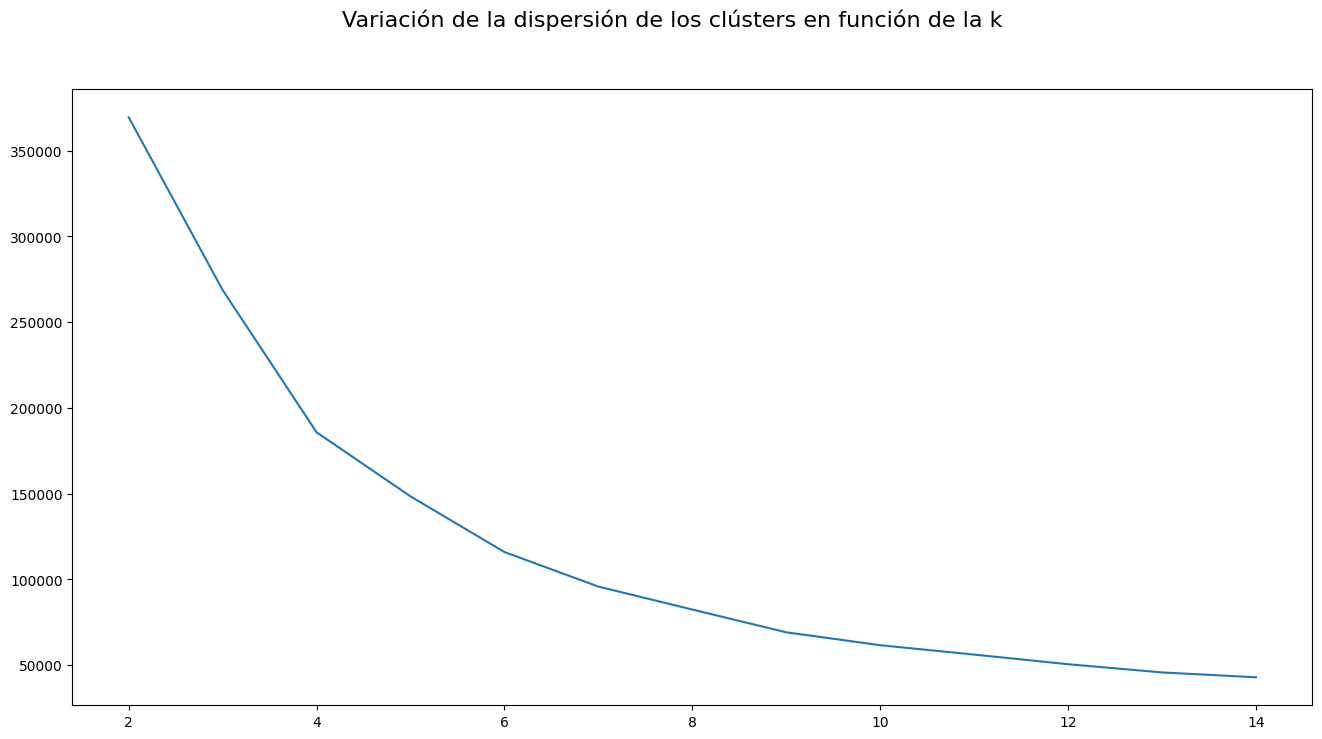

In [35]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

### Clustering

In [36]:
def clustering(df_train, df_, n_clusters):
  cluster = KMeans(n_clusters, random_state = 175)
  cluster.fit(df_train)
  labels = cluster.predict(df_train)
  df_['cluster'] = labels
  return df_

In [37]:
df_custered = clustering(df_merged_transformed, df_merged_, n_clusters =  4)
df_custered

,entry_channel_nunique,entry_channel_most_freq,act_cust_most_freq,act_cust_std,mean_products_contracted,std_products_contracted,max_products_contracted,min_products_contracted,salary,age,sales,n_product,net_margin,afiliation_days,cluster
remainder__pk_cid,,,,,,,,,,,,,,,
15891,1,KAT,0.500000,0.707107,1.589150e+04,0.707107,15892.0,15891.0,0.00,59,1.0,1.0,66.4,31,3
16063,1,KAT,0.714286,0.487950,1.606300e+04,0.000000,16063.0,16063.0,0.00,62,0.0,0.0,0.0,181,3
16203,1,KAT,0.833333,0.408248,1.620383e+04,0.408248,16204.0,16203.0,0.00,70,1.0,1.0,96.7,151,3
16502,1,Others,0.888889,0.333333,1.650344e+04,0.726483,16504.0,16502.0,0.00,58,2.0,2.0,132.9,242,2
17457,1,KAT,1.000000,0.000000,1.745924e+04,0.562296,17460.0,17458.0,102405.75,54,1.0,1.0,56.0,607,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,1,Others,0.000000,0.000000,1.553685e+06,-1.000000,1553685.0,1553685.0,0.00,52,0.0,0.0,0.0,0,2
1553686,1,Others,0.000000,0.000000,1.553686e+06,-1.000000,1553686.0,1553686.0,0.00,30,0.0,0.0,0.0,0,2
1553687,1,Others,0.000000,0.000000,1.553687e+06,-1.000000,1553687.0,1553687.0,0.00,21,0.0,0.0,0.0,0,2


In [38]:
df_custered.to_pickle('/content/drive/MyDrive/Data Science/TFM - EasyMoney/Kmeans/df_clustered.pkl')

### Analisis de clientes

In [39]:
df_custered.columns.to_list()

['entry_channel_nunique',
 'entry_channel_most_freq',
 'act_cust_most_freq',
 'act_cust_std',
 'mean_products_contracted',
 'std_products_contracted',
 'max_products_contracted',
 'min_products_contracted',
 'salary',
 'age',
 'sales',
 'n_product',
 'net_margin',
 'afiliation_days',
 'cluster']

In [40]:
df_custered = df_custered[['mean_products_contracted',
                          'std_products_contracted',
                          'salary',
                          'age',
                          'sales',
                          'n_product',
                          'net_margin',
                          'afiliation_days',
                          'cluster']]

In [41]:
df_custered.groupby('cluster').agg(
    average_age = ('age','mean'),
    average_salary = ('salary','mean'),
    average_net_margin = ('net_margin','mean'),
    average_sales = ('sales','mean'),
    average_afiliation_days = ('afiliation_days','mean')
).T

cluster,0,1,2,3
average_age,22.667836,25.259971,39.047898,40.248988
average_salary,38614.483936,93711.400129,52268.415291,94766.962167
average_net_margin,97.464261,122.693682,745.628620,489.234170
average_sales,0.799112,0.113456,1.191322,0.489921
average_afiliation_days,235.467145,954.981431,357.873253,970.967061


In [42]:
ficha_df = pd.DataFrame()

In [43]:
for i, col in enumerate(["age", "salary", "net_margin", "sales", 'afiliation_days']):
    resumen_data = df_custered[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [44]:
# generamos nuestro multiindex
inner_index = [
    "Edad",
    "Salario",
    "Beneficio",
    "Nº de compras",
    'Dias de afiliación'
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for ii, in zip(inner_index):
    for es in estadisticos:
        new_multi_index.append((ii, es))

In [45]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [46]:
names = ["Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [47]:
tamaño_clusters = df_custered.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("Clúster", "Tamaño")] , names), inplace = True)

In [48]:
ficha_df = tamaño_clusters.append(ficha_df)

In [49]:
ficha_df = ficha_df.rename(columns = {
    0 : "Clientes más jovenes, inferior salario y beneficio",
    1 : "Clientes edad < 30 y mayor beneficio",
    2 : "Clientes 30 < edad < 50 y mayor beneficio",
    3 : "Clientes 30 < edad < 50 y mayor afiliación"
})

In [50]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [51]:
df_custered.to_pickle('/content/drive/MyDrive/Data Science/TFM - EasyMoney/df_clustered.pkl')